In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture

In [0]:
url = 'https://raw.githubusercontent.com/marinaborozan/IP_projekat/master/app-store-apple-data-set-10k-apps/AppleStore.csv'
df = pd.read_csv(url)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 955.9+ KB


In [0]:
df.isnull().sum()

Unnamed: 0          0
id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64

In [89]:
rating_count_sorted = df.sort_values(by = ['rating_count_tot'], ascending = False)
rating_count_top5 = rating_count_sorted[:5]
rating_count_top5.iloc[:,[2,5,6,7,8,9,12]]

,track_name,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,prime_genre
16,Facebook,0.0,2974676,212,3.5,3.5,Social Networking
519,Instagram,0.0,2161558,1289,4.5,4.0,Photo & Video
1346,Clash of Clans,0.0,2130805,579,4.5,4.5,Games
707,Temple Run,0.0,1724546,3842,4.5,4.0,Games
7,Pandora - Music & Radio,0.0,1126879,3594,4.0,4.5,Music


In [90]:
user_rating_sorted = df.sort_values(by = ['user_rating'], ascending = False)
user_rating_top5 = user_rating_sorted[:5]
user_rating_top5.iloc[:,[2,5,6,7,8,9,12]]

,track_name,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,prime_genre
7196,Escape the Sweet Shop Series,0.00,3,3,5.0,5.0,Games
6231,激おこ!! はじめしゃちょー なんなんですか!?,0.00,1,1,5.0,5.0,Games
2531,Mini Metro,4.99,4064,338,5.0,5.0,Games
2530,"Wayfair - Shop Furniture, Home Decor, Daily Sales",0.00,12578,146,5.0,5.0,Shopping
4885,Mystic Castle - the Simplest & Best RPG and Ad...,0.00,650,488,5.0,4.5,Games


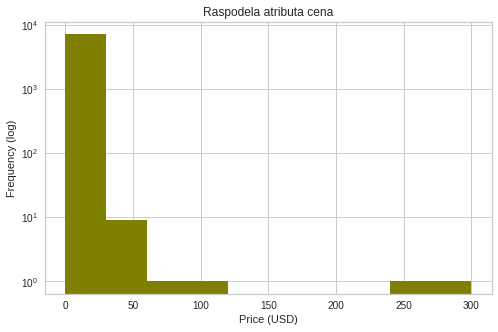

In [0]:
plt.figure(figsize=(8,5))
plt.hist(df['price'], log = True, color = 'olive')
plt.title('Raspodela atributa cena')
plt.ylabel("Frequency (log)")
plt.xlabel("Price (USD)")
plt.show()

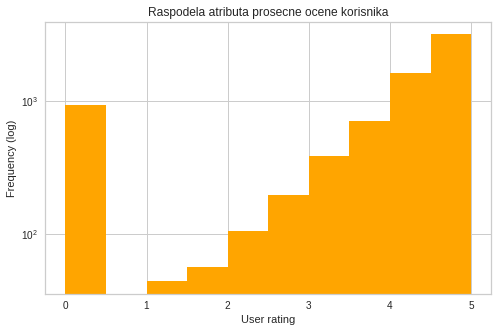

In [0]:
plt.figure(figsize=(8,5))
plt.hist(df['user_rating'], log = True, color = 'orange')
plt.title('Raspodela atributa prosecne ocene korisnika')
plt.ylabel("Frequency (log)")
plt.xlabel("User rating")
plt.show()

In [0]:
df['free'] = df['price'].apply(lambda x: 0 if x > 0 else 1)
free_apps = df['free'] == 1
paid_apps = df['free'] == 0

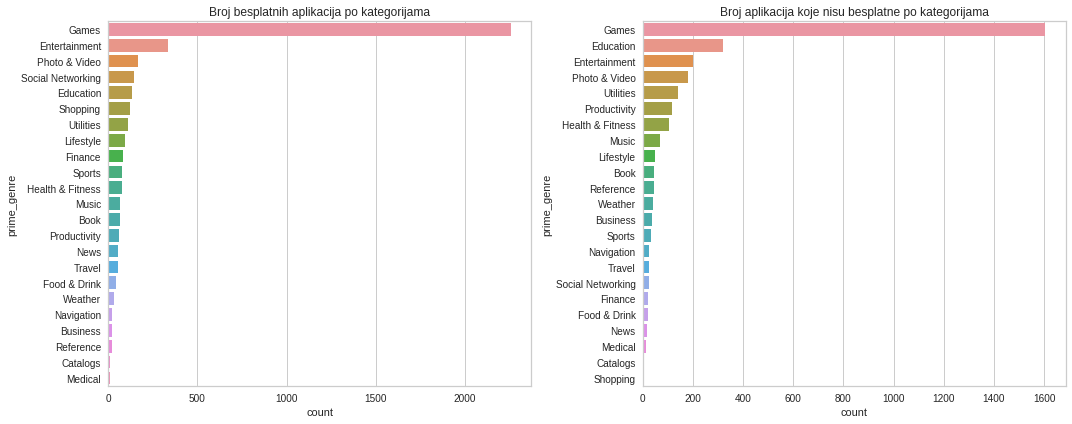

In [0]:
fig = plt.figure(figsize=(15,6))
fig.add_subplot(1,2,1)  
plt.title('Broj besplatnih aplikacija po kategorijama')
sns.countplot(y = df[free_apps]["prime_genre"], order = df[free_apps]["prime_genre"].value_counts().index)
fig.add_subplot(1,2,2) 
plt.title('Broj aplikacija koje nisu besplatne po kategorijama')
sns.countplot(y = df[paid_apps]["prime_genre"],order = df[paid_apps]["prime_genre"].value_counts().index) 
plt.tight_layout()
plt.show()

In [0]:
#b to Mb
df['size_megabytes'] = (df['size_bytes']
                    .apply (lambda x: (x / (1024 * 1024.0))))

df.drop('size_bytes', axis = 1, inplace = True)

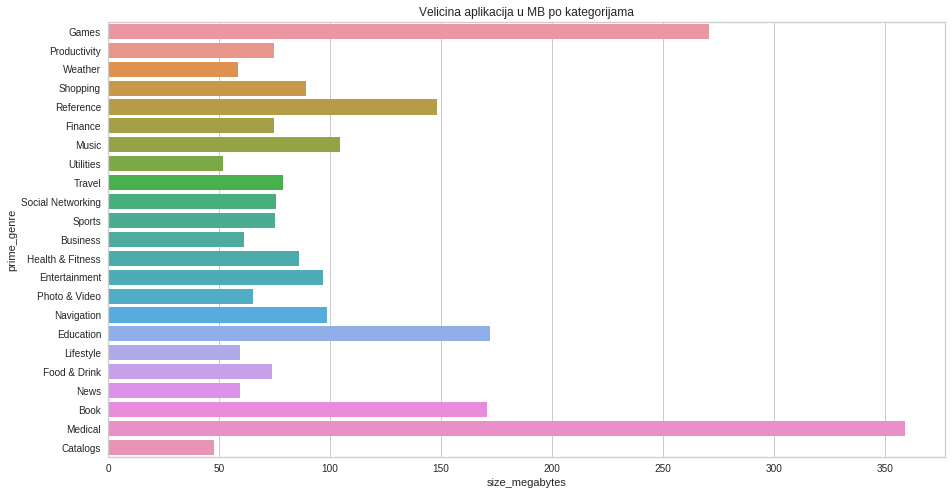

In [0]:
plt.figure(figsize = (15,8))
plt.title('Velicina aplikacija u MB po kategorijama')
sns.barplot(y = df["prime_genre"], x = (df["size_megabytes"]), ci = None)

In [0]:
#reduce genre

def reduce_genre(x):
  if(x == "Games"):
    return str(1)
  elif(x == "Entertainment"):
    return str(2)
  elif(x == "Education"):
    return str(3)
  elif(x == "Photo & Video"):
    return str(4)
  else:
    return str(5)
  
df['prime_genre'] = (df['prime_genre']
            .apply (lambda x: reduce_genre(x))
            .astype (int))

#is game
df['game'] = df['prime_genre'].apply(lambda x: 1 if x == 1 else 0)

In [0]:
#cleaning data

df['vpp_lic'] = df['vpp_lic'].astype('bool') 
df.drop('currency', axis = 1, inplace = True)
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.drop('track_name', axis = 1, inplace = True)
df.drop('id', axis = 1, inplace = True)
df = df.drop(df[df.price > 50].index)
df['cont_rating'] = (df['cont_rating']
                    .apply   (lambda x: x.replace('+',''))
                    .astype  (int))

df = df[df.user_rating != 0]

In [0]:
#function for version simplifying

def simplify_version(x):
  if(x[0] == "v" or x[0] == "V"):
    return str(x[1])
  elif(x[0] == "i"):
    return str(2)
  elif(x.startswith('Update')):
    return str(1)
  elif(len(x) > 1 and x[1] == ","): 
    return x.split(",")[0]
  else: 
    return x.split(".")[0]
    
df['ver'] = (df['ver']
            .apply (lambda x: simplify_version(x))
            .astype (int))

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6261 entries, 0 to 7196
Data columns (total 15 columns):
price               6261 non-null float64
rating_count_tot    6261 non-null int64
rating_count_ver    6261 non-null int64
user_rating         6261 non-null float64
user_rating_ver     6261 non-null float64
ver                 6261 non-null int64
cont_rating         6261 non-null int64
prime_genre         6261 non-null int64
sup_devices.num     6261 non-null int64
ipadSc_urls.num     6261 non-null int64
lang.num            6261 non-null int64
vpp_lic             6261 non-null bool
free                6261 non-null int64
size_megabytes      6261 non-null float64
game                6261 non-null int64
dtypes: bool(1), float64(4), int64(10)
memory usage: 739.8 KB


In [0]:
#SCALING DATA

features = df.columns
scaler = MinMaxScaler().fit(df[features])
x = pd.DataFrame(scaler.transform(df[features]))
x.columns = features

In [0]:
#DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit_predict(x)
max(dbscan.labels_)

3

In [0]:
df['labels'] = dbscan.labels_
df.groupby('labels').count()

,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,free,size_megabytes,game
labels,,,,,,,,,,,,,,,
-1,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78
0,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476,1476
1,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467,1467
2,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356
3,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884


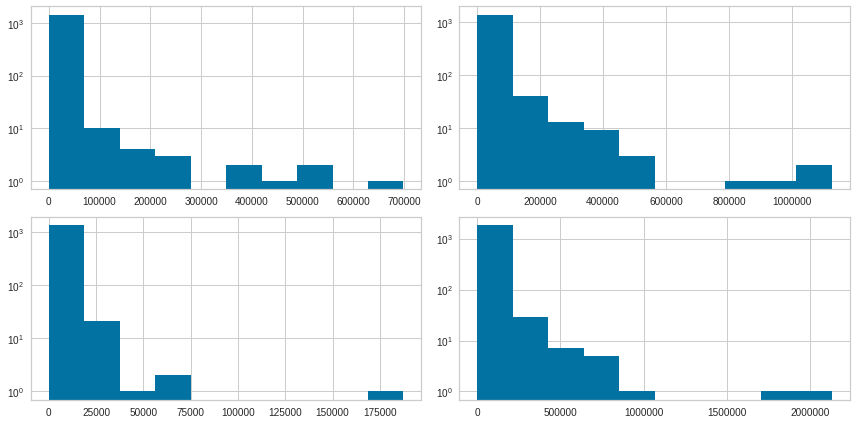

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['rating_count_tot'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

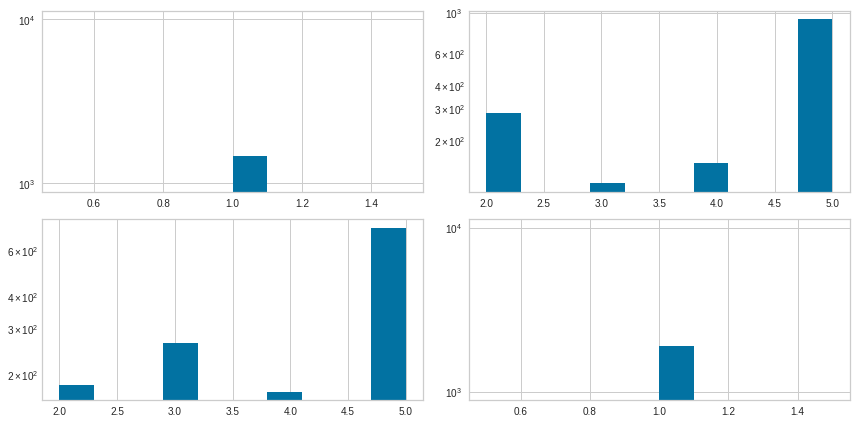

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['prime_genre'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

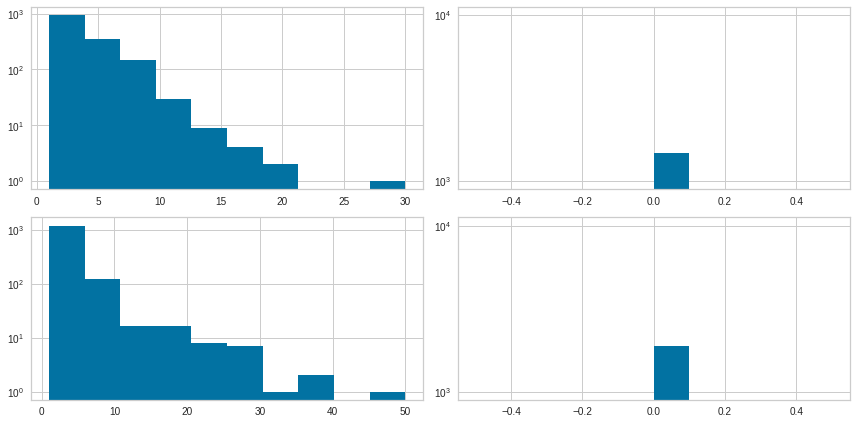

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['price'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

In [0]:
#ESTIMATE
sil_score_dbscan = silhouette_score (x, dbscan.labels_)
sil_score_dbscan

0.397276794904324

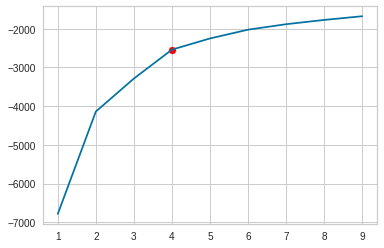

In [0]:
#KMEANS

Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(x).score(x) for i in range(len(km))]
score
plt.plot(Ks, score)
#dobili smo elbow 4 klastera
plt.scatter(4, score[3], c='red')


In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
max(kmeans.labels_)

3

In [0]:

df['labels'] = kmeans.labels_
df.groupby('labels').count()

,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,free,size_megabytes,game
labels,,,,,,,,,,,,,,,
0,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893
1,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371
2,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507
3,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490


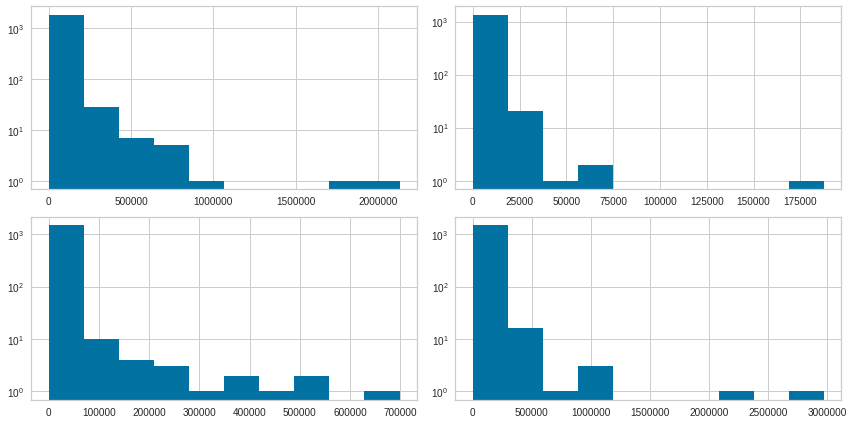

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['rating_count_tot'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

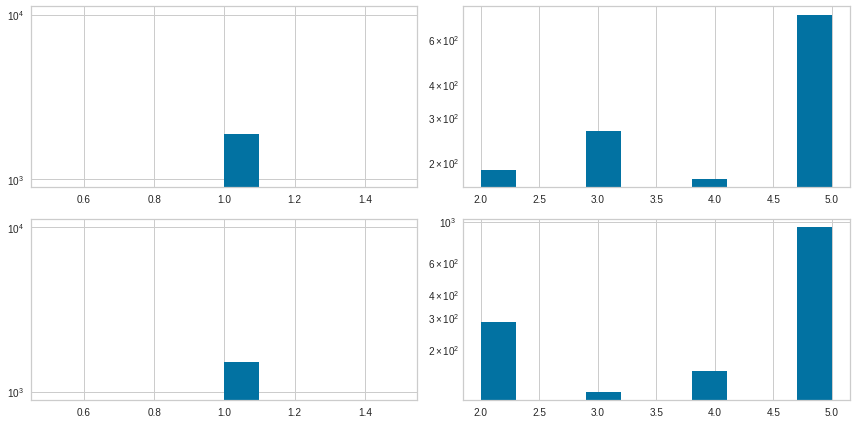

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['prime_genre'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

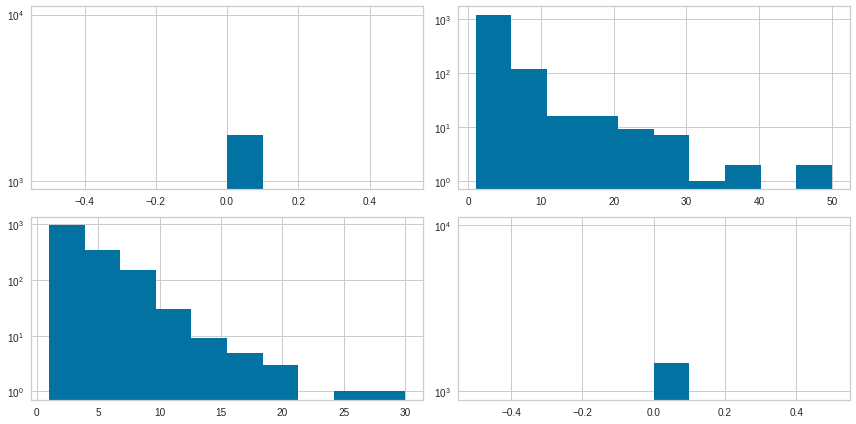

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['price'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

In [0]:
#ESTIMATE
sil_score_kmeans = silhouette_score (x, kmeans.labels_)
sil_score_kmeans

0.3999265029181792

In [0]:
#GAUSSIAN

gaussian = GaussianMixture(n_components=4)
labels = gaussian.fit_predict(x)
max(labels)

3

In [0]:
df['labels'] = labels
df.groupby('labels').count()

,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,free,size_megabytes,game
labels,,,,,,,,,,,,,,,
0,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893
1,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371
2,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507,1507
3,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490


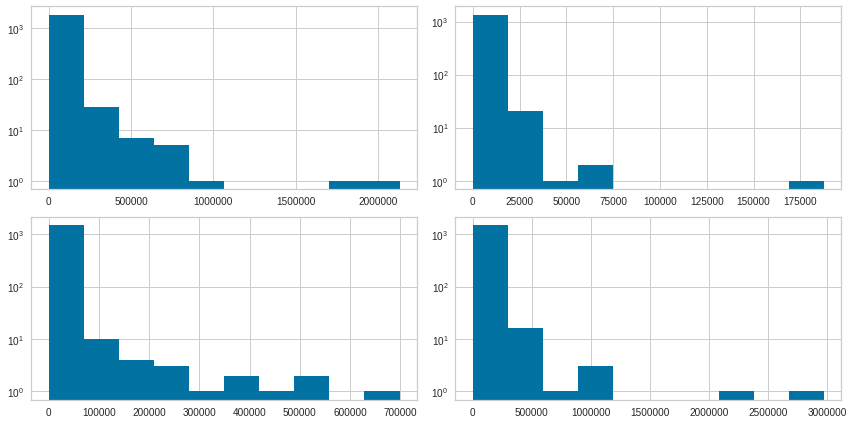

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['rating_count_tot'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

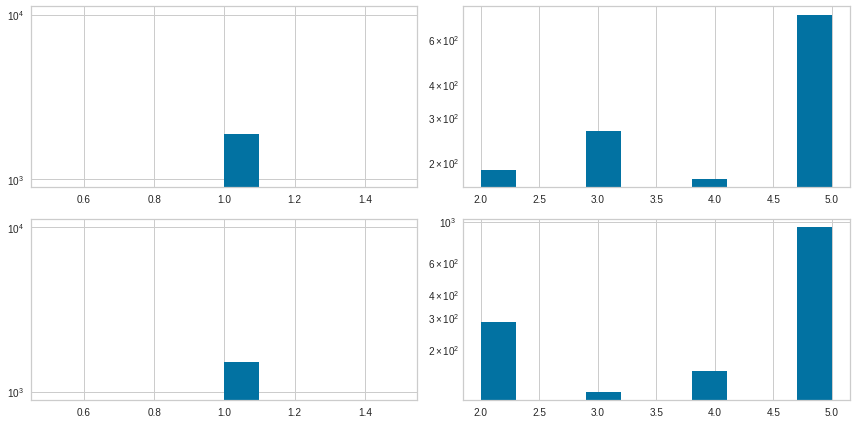

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['prime_genre'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

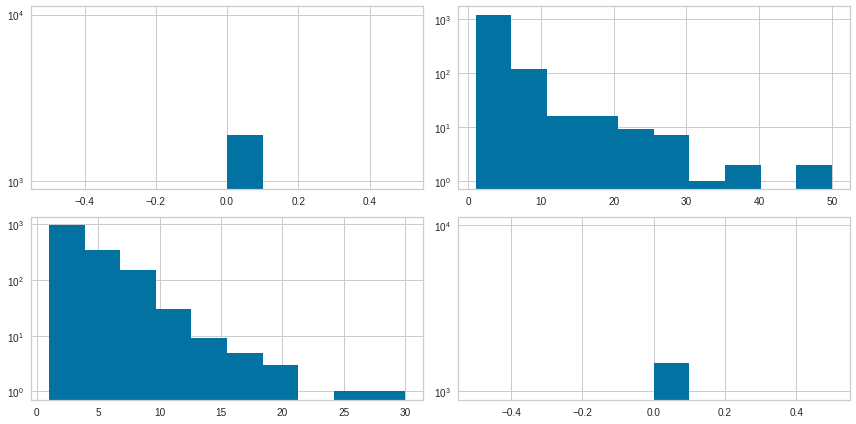

In [0]:
#VISUALIZE
fig = plt.figure(figsize=(12,6))
plt_ind=1
for i in range(0,4):
    cl = df['labels'] == i
    sp =fig.add_subplot(2,2,plt_ind)  
    plt.hist(df[cl]['price'], log = True)
    plt_ind+=1

plt.tight_layout()
plt.show()

In [0]:
#ESTIMATE
sil_score_gaussian = silhouette_score (x, labels)
sil_score_gaussian

0.3999265029181792